# Image registration (brain)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from matplotlib.pyplot import imread
import tensorflow as tf
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt

drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/KU/MIA' 
os.chdir(root_path)

Mounted at /content/gdrive


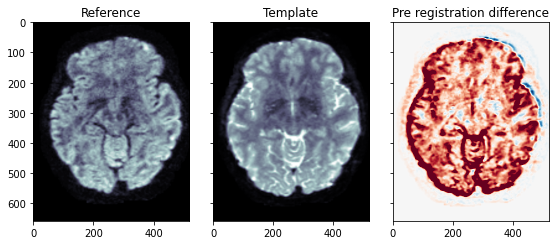

In [2]:
# Load data
B1 = imread("Data4/B1.png")[:,:-1,0]
B2 = imread("Data4/B2.png")[:,:,0]

# Plotting function
def plot_diff(tem, ref, reg=None, filename=None):
  if reg==None:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (8, 4), sharex=True, sharey=True)
    ax1.imshow(ref, cmap = 'bone')
    ax1.set_title('Reference')
    ax2.imshow(tem, cmap = 'bone')
    ax2.set_title('Template')
    ax3.imshow(ref-tem, vmin = -0.35, vmax=0.35, cmap = 'RdBu') 
    ax3.set_title('Pre registration difference')
  else:
    fig, ((ax1, ax2, ax3), 
          (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize = (8, 6.8), 
                                          sharex=True, sharey=True)
    ax1.imshow(ref, cmap = 'bone')
    ax1.set_title('Reference')
    ax2.imshow(tem, cmap = 'bone')
    ax2.set_title('Template')
    ax3.imshow(ref-tem, vmin = -0.35, vmax=0.35, cmap = 'RdBu') 
    ax3.set_title('Pre registration difference')
    ax4.imshow(ref, cmap = 'bone')
    ax4.set_title('Reference')
    ax5.imshow(reg, cmap = 'bone')
    ax5.set_title('Registered template')
    ax6.imshow(ref-reg, vmin = -0.35, vmax=0.35, cmap = 'RdBu') 
    ax6.set_title('Post registration difference')
  fig.tight_layout()
  if filename!=None:
    plt.savefig(f"./Week7/plots_handin4/{filename}.png", dpi=300)
  plt.show()

plot_diff(B1, B2, filename="Images_pre_registration")

## Spatial transformer network

In [3]:
# Spatial transformer network
def transformer(U, theta, out_size, name='SpatialTransformer', **kwargs):
    """Spatial Transformer Layer
    Implements a spatial transformer layer as described in [1]_.
    Based on [2]_ and edited by David Dao for Tensorflow.
    Parameters
    ----------
    U : float
        The output of a convolutional net should have the
        shape [num_batch, height, width, num_channels].
    theta: float
        The output of the
        localisation network should be [num_batch, 6].
    out_size: tuple of two ints
        The size of the output of the network (height, width)
    References
    ----------
    .. [1]  Spatial Transformer Networks
            Max Jaderberg, Karen Simonyan, Andrew Zisserman, Koray Kavukcuoglu
            Submitted on 5 Jun 2015
    .. [2]  https://github.com/skaae/transformer_network/blob/master/transformerlayer.py
    Notes
    -----
    To initialize the network to the identity transform init
    ``theta`` to :
        identity = np.array([[1., 0., 0.],
                             [0., 1., 0.]])
        identity = identity.flatten()
        theta = tf.Variable(initial_value=identity)
    """

    def _repeat(x, n_repeats):
      rep = tf.transpose(
          tf.expand_dims(tf.ones(shape=tf.stack([n_repeats, ])), 1), [1, 0])
      rep = tf.cast(rep, 'int32')
      x = tf.matmul(tf.reshape(x, (-1, 1)), rep)
      return tf.reshape(x, [-1])

    def _interpolate(im, x, y, out_size):
      # constants
      num_batch = tf.shape(im)[0]
      height = tf.shape(im)[1]
      width = tf.shape(im)[2]
      channels = tf.shape(im)[3]

      x = tf.cast(x, 'float32')
      y = tf.cast(y, 'float32')
      height_f = tf.cast(height, 'float32')
      width_f = tf.cast(width, 'float32')
      out_height = out_size[0]
      out_width = out_size[1]
      zero = tf.zeros([], dtype='int32')
      max_y = tf.cast(tf.shape(im)[1] - 1, 'int32')
      max_x = tf.cast(tf.shape(im)[2] - 1, 'int32')

      # scale indices from [-1, 1] to [0, width/height]
      x = (x + 1.0)*(width_f) / 2.0
      y = (y + 1.0)*(height_f) / 2.0

      # do sampling
      x0 = tf.cast(tf.floor(x), 'int32')
      x1 = x0 + 1
      y0 = tf.cast(tf.floor(y), 'int32')
      y1 = y0 + 1

      x0 = tf.clip_by_value(x0, zero, max_x)
      x1 = tf.clip_by_value(x1, zero, max_x)
      y0 = tf.clip_by_value(y0, zero, max_y)
      y1 = tf.clip_by_value(y1, zero, max_y)
      dim2 = width
      dim1 = width*height
      base = _repeat(tf.range(num_batch)*dim1, out_height*out_width)
      base_y0 = base + y0*dim2
      base_y1 = base + y1*dim2
      idx_a = base_y0 + x0
      idx_b = base_y1 + x0
      idx_c = base_y0 + x1
      idx_d = base_y1 + x1

      # use indices to lookup pixels in the flat image and restore
      # channels dim
      im_flat = tf.reshape(im, tf.stack([-1, channels]))
      im_flat = tf.cast(im_flat, 'float32')
      Ia = tf.gather(im_flat, idx_a)
      Ib = tf.gather(im_flat, idx_b)
      Ic = tf.gather(im_flat, idx_c)
      Id = tf.gather(im_flat, idx_d)

      # and finally calculate interpolated values
      x0_f = tf.cast(x0, 'float32')
      x1_f = tf.cast(x1, 'float32')
      y0_f = tf.cast(y0, 'float32')
      y1_f = tf.cast(y1, 'float32')
      wa = tf.expand_dims(((x1_f-x) * (y1_f-y)), 1)
      wb = tf.expand_dims(((x1_f-x) * (y-y0_f)), 1)
      wc = tf.expand_dims(((x-x0_f) * (y1_f-y)), 1)
      wd = tf.expand_dims(((x-x0_f) * (y-y0_f)), 1)
      output = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])
      return output

    def _meshgrid(height, width):
      # This should be equivalent to:
      #  x_t, y_t = np.meshgrid(np.linspace(-1, 1, width),
      #                         np.linspace(-1, 1, height))
      #  ones = np.ones(np.prod(x_t.shape))
      #  grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])
      x_t = tf.matmul(tf.ones(shape=tf.stack([height, 1])),
                      tf.transpose(tf.expand_dims(tf.linspace(-1.0, 1.0, width), 1), [1, 0]))
      y_t = tf.matmul(tf.expand_dims(tf.linspace(-1.0, 1.0, height), 1),
                      tf.ones(shape=tf.stack([1, width])))

      x_t_flat = tf.reshape(x_t, (1, -1))
      y_t_flat = tf.reshape(y_t, (1, -1))

      ones = tf.ones_like(x_t_flat)
      grid = tf.concat([x_t_flat, y_t_flat, ones], 0)
      return grid

    def _transform(theta, input_dim, out_size):
      num_batch = tf.shape(input_dim)[0]
      height = tf.shape(input_dim)[1]
      width = tf.shape(input_dim)[2]
      num_channels = tf.shape(input_dim)[3]
      theta = tf.reshape(theta, (-1, 2, 3))
      theta = tf.cast(theta, 'float32')

      # grid of (x_t, y_t, 1), eq (1) in ref [1]
      height_f = tf.cast(height, 'float32')
      width_f = tf.cast(width, 'float32')
      out_height = out_size[0]
      out_width = out_size[1]
      grid = _meshgrid(out_height, out_width)
      grid = tf.expand_dims(grid, 0)
      grid = tf.reshape(grid, [-1])
      grid = tf.tile(grid, tf.stack([num_batch]))
      grid = tf.reshape(grid, tf.stack([num_batch, 3, -1]))

      # Transform A x (x_t, y_t, 1)^T -> (x_s, y_s)
      T_g = tf.matmul(theta, grid)
      x_s = tf.slice(T_g, [0, 0, 0], [-1, 1, -1])
      y_s = tf.slice(T_g, [0, 1, 0], [-1, 1, -1])
      x_s_flat = tf.reshape(x_s, [-1])
      y_s_flat = tf.reshape(y_s, [-1])

      input_transformed = _interpolate(
          input_dim, x_s_flat, y_s_flat,
          out_size)

      output = tf.reshape(
          input_transformed, tf.stack([num_batch, out_height, out_width, num_channels]))
      return output

    output = _transform(theta, U, out_size)
    return output[0,:,:,0]

## Similarity measures

In [4]:
# Similariry measures

def sse(x, y):
  return tf.reduce_sum((x - y)**2)

def cross_corr(x,y):
  d = tf.reduce_sum(( (x - tf.reduce_mean(x)) * (y - tf.reduce_mean(y)) ))
  n = (B1.shape[0] * B1.shape[1]) * (tf.math.reduce_std(x) * tf.math.reduce_std(y))
  return d / n

## Rigid transformation registration

In [5]:
# Rigid transformation registration

def rigid(par):
  return tf.reshape(tf.convert_to_tensor([tf.cos(par[0]), -tf.sin(par[0]), par[1], 
                                          tf.sin(par[0]),  tf.cos(par[0]), par[2]]), shape=6)

def rigid_registration(tem, ref, iterations, l_rate, out_size, metric="sse", 
                       n_channels=1):
  # Reshape the image and set the output size
  im = tem.copy()
  im = im.reshape(1, tem.shape[0], tem.shape[1], n_channels)
  im = im.astype('float32')

  # Set batch as 1 image
  batch = im
  num_batch = 1

  # Create a fully-connected layer with 6 output nodes
  n_fc = 6
  W_fc1 = tf.constant(tf.zeros([B1.shape[1] * B1.shape[0] * n_channels, n_fc]), name='W_fc1')

  # Initialize theta, x, and y and the transformation matrix
  w = tf.Variable([0.0,0.0,0.0])
  b_fc1 = rigid(w)

  # Optimization
  opt = tf.optimizers.Adam(learning_rate=lr)
  loss_rigid = []
  for i in range(iterations):
    with tf.GradientTape(persistent=True) as tape:
      h_fc1 = tf.matmul(tf.zeros([num_batch, B1.shape[1] * B1.shape[0] * n_channels]), W_fc1) + rigid(w)
      # Define the loss
      if metric == "sse":
        loss = tf.reduce_sum((B2 - transformer(batch, h_fc1, out_size))**2)
        loss_rigid.append(loss)
        print(f'SSE: {loss:.8} ({i})')
      else:
        loss = -cross_corr(B2, transformer(batch, h_fc1, out_size))
        loss_rigid.append(-loss)
        print(f'CC: {-loss:.5} ({i})')
    # Get gradient and pdate weights    
    dl_dw = tape.gradient(loss, w)
    opt.apply_gradients(zip([dl_dw], [w]))

  return w, loss_rigid

def apply_rigid_transform(tem, w, n_channels=1):
  # Reshape the image and set the output size
  im = tem.copy()
  im = im.reshape(1, tem.shape[0], tem.shape[1], n_channels)
  im = im.astype('float32')
  # Set num batch as 1 image
  batch = im
  num_batch = 1
  # Apply transformation
  n_fc = 6
  W_fc1 = tf.constant(tf.zeros([B1.shape[1] * B1.shape[0] * n_channels, n_fc]), name='W_fc1')
  h_fc1 = tf.matmul(tf.zeros([num_batch, B1.shape[1] * B1.shape[0] * n_channels]), W_fc1) + rigid(w)
  B3_rigid = transformer(batch, h_fc1, out_size)
  return B3_rigid

 ### Rigid registration SSE

SSE: 12379.688 (0)
SSE: 11966.715 (1)
SSE: 11633.954 (2)
SSE: 11399.605 (3)
SSE: 11265.358 (4)
SSE: 11215.624 (5)
SSE: 11220.68 (6)
SSE: 11251.047 (7)
SSE: 11284.754 (8)
SSE: 11311.69 (9)
SSE: 11322.639 (10)
SSE: 11322.014 (11)
SSE: 11308.998 (12)
SSE: 11288.552 (13)
SSE: 11262.259 (14)
SSE: 11237.948 (15)
SSE: 11215.571 (16)
SSE: 11199.381 (17)
SSE: 11185.729 (18)
SSE: 11176.35 (19)
SSE: 11172.502 (20)
SSE: 11173.314 (21)
SSE: 11178.049 (22)
SSE: 11185.892 (23)
SSE: 11192.588 (24)
SSE: 11196.301 (25)
SSE: 11195.579 (26)
SSE: 11191.13 (27)
SSE: 11183.81 (28)
SSE: 11175.327 (29)
SSE: 11166.095 (30)
SSE: 11160.097 (31)
SSE: 11156.726 (32)
SSE: 11157.988 (33)
SSE: 11161.692 (34)
SSE: 11166.441 (35)
SSE: 11169.751 (36)
SSE: 11170.657 (37)
SSE: 11169.211 (38)
SSE: 11166.225 (39)
SSE: 11163.386 (40)
SSE: 11160.902 (41)
SSE: 11159.128 (42)
SSE: 11158.784 (43)
SSE: 11159.113 (44)
SSE: 11159.052 (45)
SSE: 11158.673 (46)
SSE: 11158.848 (47)
SSE: 11159.68 (48)
SSE: 11160.417 (49)
SSE: 11160.573 (

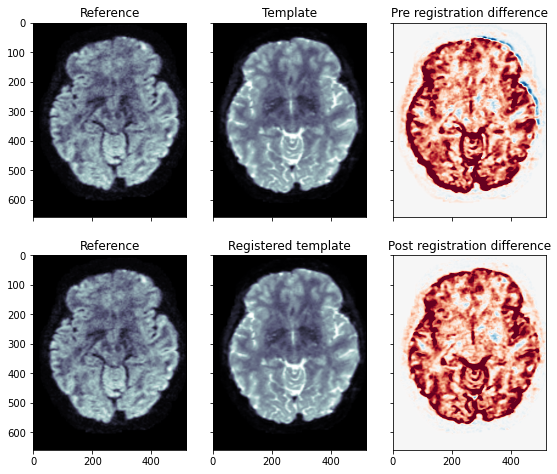

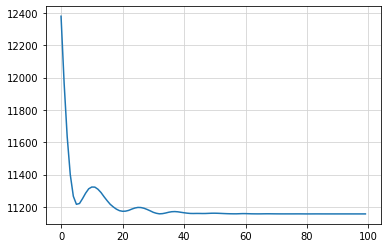

Final R tf.Tensor([ 0.99996513 -0.0083525  -0.02947515  0.0083525   0.99996513  0.01997841], shape=(6,), dtype=float32)
Final t, x, y <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.0083526 , -0.02947515,  0.01997841], dtype=float32)>


In [6]:
# Rigid transformation registration SSE

# Obtain optimal transformation
out_size = (B2.shape[0], B2.shape[1])
n_channels = 1
num_batch = 1
iterations = 100
lr = 0.005
w, loss_rigid_sse = rigid_registration(tem=B1, ref=B2, iterations=iterations, 
                                       l_rate=lr, out_size=out_size)

# Apply optimal tranformation
B3_rigid_sse = apply_rigid_transform(B1, w)

# Plot
plot_diff(B1, B2, B3_rigid_sse, filename="Images_rigid_registration_SSE")
plt.plot(loss_rigid_sse)
plt.grid(zorder=0, color="lightgray")
plt.show()

print("Final R", rigid(w))
print("Final t, x, y", w)

## Rigid registration CC

CC: 0.87461 (0)
CC: 0.88526 (1)
CC: 0.8938 (2)
CC: 0.89983 (3)
CC: 0.90329 (4)
CC: 0.90457 (5)
CC: 0.90444 (6)
CC: 0.90367 (7)
CC: 0.9028 (8)
CC: 0.90211 (9)
CC: 0.90181 (10)
CC: 0.90183 (11)
CC: 0.90216 (12)
CC: 0.9027 (13)
CC: 0.90335 (14)
CC: 0.90398 (15)
CC: 0.90455 (16)
CC: 0.90497 (17)
CC: 0.90532 (18)
CC: 0.90555 (19)
CC: 0.90565 (20)
CC: 0.90561 (21)
CC: 0.90549 (22)
CC: 0.90531 (23)
CC: 0.90515 (24)
CC: 0.90505 (25)
CC: 0.90507 (26)
CC: 0.90518 (27)
CC: 0.90536 (28)
CC: 0.90559 (29)
CC: 0.90581 (30)
CC: 0.90596 (31)
CC: 0.90604 (32)
CC: 0.90602 (33)
CC: 0.90595 (34)
CC: 0.90586 (35)
CC: 0.90578 (36)
CC: 0.90575 (37)
CC: 0.90577 (38)
CC: 0.90582 (39)
CC: 0.90588 (40)
CC: 0.90594 (41)
CC: 0.90599 (42)
CC: 0.90601 (43)
CC: 0.90601 (44)
CC: 0.90601 (45)
CC: 0.90601 (46)
CC: 0.90602 (47)
CC: 0.90602 (48)
CC: 0.90601 (49)
CC: 0.906 (50)
CC: 0.906 (51)
CC: 0.90602 (52)
CC: 0.90603 (53)
CC: 0.90604 (54)
CC: 0.90606 (55)
CC: 0.90607 (56)
CC: 0.90607 (57)
CC: 0.90606 (58)
CC: 0.90605 (5

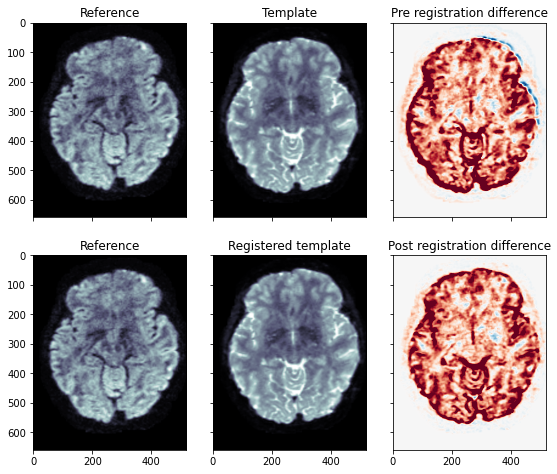

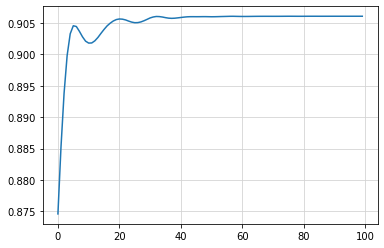

Final R tf.Tensor([ 0.99996287 -0.00861582 -0.02945363  0.00861582  0.99996287  0.01993693], shape=(6,), dtype=float32)
Final t, x, y <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.00861593, -0.02945363,  0.01993693], dtype=float32)>


In [7]:
# Rigid transformation registration CC

# Obtain optimal transformation
out_size = (B2.shape[0], B2.shape[1])
iterations = 100
lr = 0.005
w, loss_rigid_cc = rigid_registration(tem=B1, ref=B2, iterations=iterations, 
                                      l_rate=lr, metric="cc", out_size=out_size)

# Apply optimal tranformation
B3_rigid_cc = apply_rigid_transform(B1, w)

# Plot
plot_diff(B1, B2, B3_rigid_cc, filename="Images_rigid_registration_CC")
plt.plot(loss_rigid_cc)
plt.grid(zorder=0, color="lightgray")
plt.show()

print("Final R", rigid(w))
print("Final t, x, y", w)

## Affine transformation registration

In [8]:
# Affine transformation registration

def affine_registration(tem, ref, iterations, l_rate, out_size, 
                        metric="sse", n_channels=1):
  # Reshape the image
  im = tem.copy()
  im = im.reshape(1, tem.shape[0], tem.shape[1], n_channels)
  im = im.astype('float32')

  # Simulate batch
  batch = np.append(im, im, axis=0)
  num_batch = 2

  # Create a fully-connected layer with 6 output nodes
  n_fc = 6
  W_fc1 = tf.constant(tf.zeros([B1.shape[1] * B1.shape[0] * n_channels, n_fc]), name='W_fc1')

  # Initialize the parameters and the transformation as the identity matrix 
  initial = np.array([[1, 0, 0], [0, 1, 0]])
  initial = initial.astype('float32')
  initial = initial.flatten()
  b_fc1 = tf.Variable(initial_value=initial, name='b_fc1') 

  # Optimization
  opt = tf.optimizers.Adam(learning_rate=lr)
  loss_affine = []
  for i in range(iterations):
    with tf.GradientTape(persistent=True) as tape:
      h_fc1 = tf.matmul(tf.zeros([num_batch, B1.shape[1] * B1.shape[0] * n_channels]), W_fc1) + b_fc1
      # Define the loss
      if metric == "sse":
        loss = tf.reduce_sum((B2 - transformer(batch, h_fc1, out_size))**2)
        loss_affine.append(loss)
        print(f'SSE: {loss:.8} ({i})')
      else:
        loss = -cross_corr(B2, transformer(batch, h_fc1, out_size))
        loss_affine.append(-loss)
        print(f'CC: {-loss:.5} ({i})')
    # Get gradient and update weights   
    dl_db_fc1 = tape.gradient(loss, b_fc1)
    opt.apply_gradients(zip([dl_db_fc1], [b_fc1]))  
  
  return b_fc1, loss_affine

def apply_affine_transform(tem, R, n_channels=1):
  # Reshape the image and set the output size
  im = tem.copy()
  im = im.reshape(1, tem.shape[0], tem.shape[1], n_channels)
  im = im.astype('float32')
  # Set num batch as 1 image
  batch = im
  num_batch = 1
  # Apply transformation
  n_fc = 6
  W_fc1 = tf.constant(tf.zeros([B1.shape[1] * B1.shape[0] * n_channels, n_fc]), name='W_fc1')
  h_fc1 = tf.matmul(tf.zeros([num_batch, B1.shape[1] * B1.shape[0] * n_channels]), W_fc1) + R
  B3_affine = transformer(batch, h_fc1, out_size)
  return B3_affine

### Affine registration SSE

SSE: 12379.688 (0)
SSE: 11553.125 (1)
SSE: 10862.611 (2)
SSE: 10313.753 (3)
SSE: 9904.2061 (4)
SSE: 9651.9688 (5)
SSE: 9539.9326 (6)
SSE: 9518.1309 (7)
SSE: 9542.1543 (8)
SSE: 9583.168 (9)
SSE: 9625.7578 (10)
SSE: 9662.5176 (11)
SSE: 9687.7461 (12)
SSE: 9702.2949 (13)
SSE: 9705.9277 (14)
SSE: 9698.2988 (15)
SSE: 9682.4355 (16)
SSE: 9661.6152 (17)
SSE: 9637.0986 (18)
SSE: 9613.1797 (19)
SSE: 9593.2158 (20)
SSE: 9576.1582 (21)
SSE: 9561.1768 (22)
SSE: 9546.7422 (23)
SSE: 9528.5186 (24)
SSE: 9507.3047 (25)
SSE: 9482.1895 (26)
SSE: 9458.3281 (27)
SSE: 9438.4189 (28)
SSE: 9429.2324 (29)
SSE: 9431.6152 (30)
SSE: 9442.7607 (31)
SSE: 9454.9395 (32)
SSE: 9465.8057 (33)
SSE: 9469.6318 (34)
SSE: 9466.2168 (35)
SSE: 9455.7129 (36)
SSE: 9444.7529 (37)
SSE: 9436.4688 (38)
SSE: 9432.4336 (39)
SSE: 9433.9248 (40)
SSE: 9433.9111 (41)
SSE: 9433.4473 (42)
SSE: 9431.6523 (43)
SSE: 9428.8281 (44)
SSE: 9427.0195 (45)
SSE: 9426.4668 (46)
SSE: 9426.502 (47)
SSE: 9426.7051 (48)
SSE: 9428.0752 (49)
SSE: 9429.71

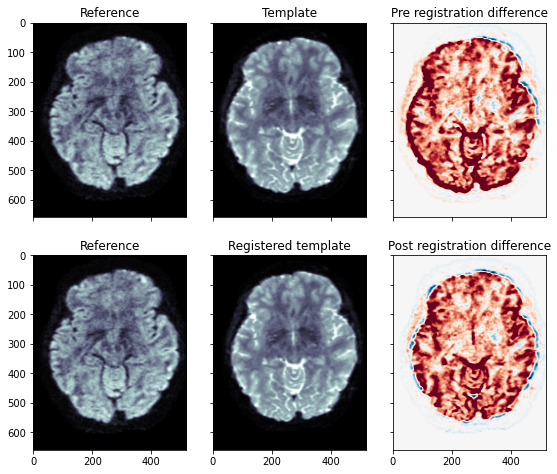

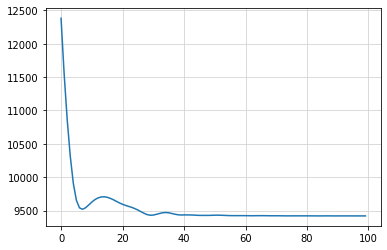

Final R <tf.Variable 'b_fc1:0' shape=(6,) dtype=float32, numpy=
array([ 1.0383579 ,  0.00605226, -0.03242876,  0.00488626,  1.03308   ,
        0.01867392], dtype=float32)>


In [9]:
# Affine transformation registration SSE

# Obtain optimal tranformation
out_size = (B2.shape[0], B2.shape[1])
n_channels=1
iterations = 100
lr = 0.005
R, loss_affine_sse = affine_registration(tem=B1, ref=B2, iterations=iterations, 
                                         l_rate=lr, out_size=out_size)

# Apply optimal tranformation
B3_affine_sse = apply_affine_transform(B1, R) 

# Plot
plot_diff(B1, B2, B3_affine_sse, filename="Images_affine_registration_SSE")
plt.plot(loss_affine_sse)
plt.grid(zorder=0, color="lightgray")
plt.show()

print("Final R", R)

### Affine registration CC

CC: 0.87461 (0)
CC: 0.8904 (1)
CC: 0.90283 (2)
CC: 0.91172 (3)
CC: 0.91734 (4)
CC: 0.91952 (5)
CC: 0.91918 (6)
CC: 0.91789 (7)
CC: 0.91673 (8)
CC: 0.91607 (9)
CC: 0.91598 (10)
CC: 0.91633 (11)
CC: 0.917 (12)
CC: 0.9178 (13)
CC: 0.91858 (14)
CC: 0.91916 (15)
CC: 0.91954 (16)
CC: 0.91989 (17)
CC: 0.92025 (18)
CC: 0.92069 (19)
CC: 0.92116 (20)
CC: 0.92154 (21)
CC: 0.92175 (22)
CC: 0.92174 (23)
CC: 0.92153 (24)
CC: 0.92122 (25)
CC: 0.92094 (26)
CC: 0.92082 (27)
CC: 0.92091 (28)
CC: 0.92118 (29)
CC: 0.92157 (30)
CC: 0.92193 (31)
CC: 0.92217 (32)
CC: 0.92228 (33)
CC: 0.92223 (34)
CC: 0.92211 (35)
CC: 0.922 (36)
CC: 0.92194 (37)
CC: 0.92196 (38)
CC: 0.92202 (39)
CC: 0.9221 (40)
CC: 0.92215 (41)
CC: 0.92216 (42)
CC: 0.92216 (43)
CC: 0.92217 (44)
CC: 0.92219 (45)
CC: 0.92224 (46)
CC: 0.92229 (47)
CC: 0.92232 (48)
CC: 0.92232 (49)
CC: 0.9223 (50)
CC: 0.92227 (51)
CC: 0.92226 (52)
CC: 0.92226 (53)
CC: 0.92228 (54)
CC: 0.92231 (55)
CC: 0.92234 (56)
CC: 0.92234 (57)
CC: 0.92234 (58)
CC: 0.92233 (59

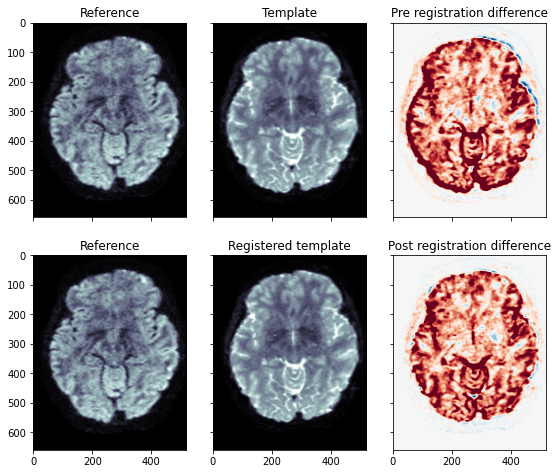

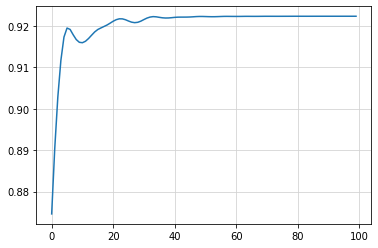

Final R <tf.Variable 'b_fc1:0' shape=(6,) dtype=float32, numpy=
array([ 1.0183468 ,  0.0015185 , -0.03156377,  0.00822237,  1.0225298 ,
        0.01990296], dtype=float32)>


In [10]:
# Affine transformation registration cc

# Obtain optimal tranformation
out_size = (B2.shape[0], B2.shape[1])
n_channels=1
iterations = 100
lr = 0.005
R, loss_affine_cc = affine_registration(tem=B1, ref=B2, iterations=iterations, 
                                         l_rate=lr, metric="cc", out_size=out_size)

# Apply optimal tranformation
B3_affine_cc = apply_affine_transform(B1, R) 

# Plot
plot_diff(B1, B2, B3_affine_cc, filename="Images_affine_registration_CC")
plt.plot(loss_affine_cc)
plt.grid(zorder=0, color="lightgray")
plt.show()

print("Final R", R)

## Final plots

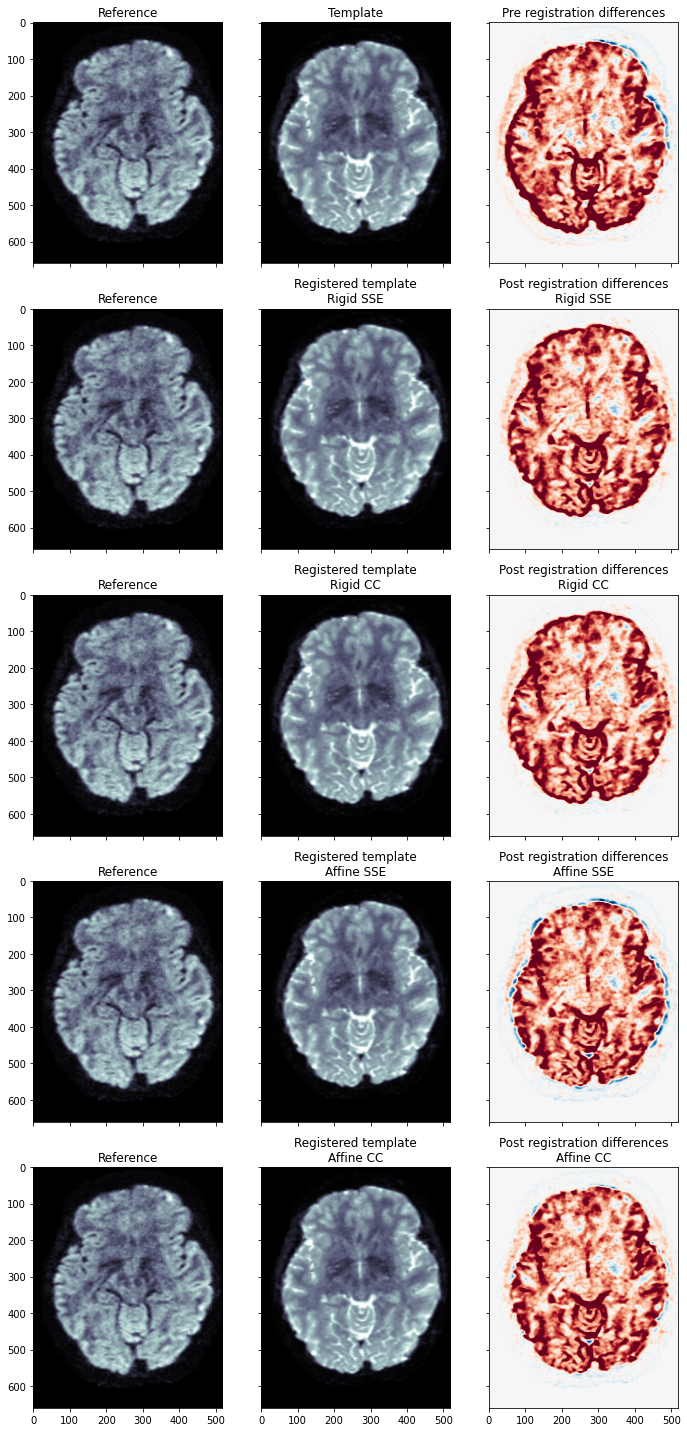

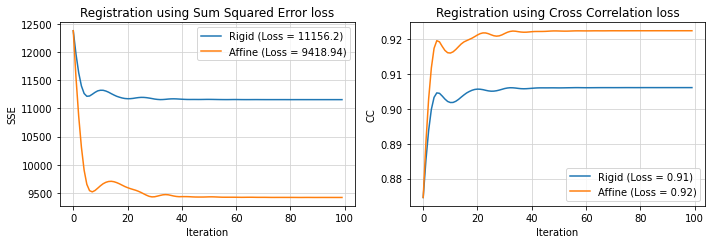

In [11]:
# Final plot images
fig, ((ax1, ax2, ax3), 
      (ax4, ax5, ax6),
      (ax7, ax8, ax9),
      (ax10, ax11, ax12),
      (ax13, ax14, ax15)) = plt.subplots(nrows=5, ncols=3, figsize = (10,20), 
                                         sharex=True, sharey=True)
ax1.imshow(B2, cmap = 'bone')
ax1.set_title('Reference')
ax2.imshow(B1, cmap = 'bone')
ax2.set_title('Template')
ax3.imshow(1.0*B2-B1, vmin = -0.35, vmax=0.35, cmap = 'RdBu') 
ax3.set_title('Pre registration differences')

ax4.imshow(B2, cmap = 'bone')
ax4.set_title('Reference')
ax5.imshow(B3_rigid_sse, cmap = 'bone')
ax5.set_title('Registered template\nRigid SSE')
ax6.imshow(1.0*B2-B3_rigid_sse, vmin = -0.35, vmax=0.35, cmap = 'RdBu') 
ax6.set_title('Post registration differences\nRigid SSE')

ax7.imshow(B2, cmap = 'bone')
ax7.set_title('Reference')
ax8.imshow(B3_rigid_cc, cmap = 'bone')
ax8.set_title('Registered template\nRigid CC')
ax9.imshow(1.0*B2-B3_rigid_cc, vmin = -0.35, vmax=0.35, cmap = 'RdBu') 
ax9.set_title('Post registration differences\nRigid CC')

ax10.imshow(B2, cmap = 'bone')
ax10.set_title('Reference')
ax11.imshow(B3_affine_sse, cmap = 'bone')
ax11.set_title('Registered template\nAffine SSE')
ax12.imshow(1.0*B2-B3_affine_sse, vmin = -0.35, vmax=0.35, cmap = 'RdBu') 
ax12.set_title('Post registration differences\nAffine SSE')

ax13.imshow(B2, cmap = 'bone')
ax13.set_title('Reference')
ax14.imshow(B3_affine_cc, cmap = 'bone')
ax14.set_title('Registered template\nAffine CC')
ax15.imshow(1.0*B2-B3_affine_cc, vmin = -0.35, vmax=0.35, cmap = 'RdBu') 
ax15.set_title('Post registration differences\nAffine CC')

fig.tight_layout()
plt.savefig(f"./Week7/plots_handin4/images_merged_brains.png", dpi=300)
plt.show()


# Final plot loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 3.5))
ax1.plot(loss_rigid_sse, label = f"Rigid (Loss = {loss_rigid_sse[len(loss_rigid_sse)-1]:.6})")
ax1.plot(loss_affine_sse, label = f"Affine (Loss = {loss_affine_sse[len(loss_affine_sse)-1]:.6})")
ax1.set_title('Registration using Sum Squared Error loss')
ax1.set_ylabel("SSE")
ax1.set_xlabel("Iteration")
ax1.grid(zorder=0, color="lightgray")
ax1.legend()
ax2.plot(loss_rigid_cc, label = f"Rigid (Loss = {loss_rigid_cc[len(loss_rigid_cc)-1]:.2})")
ax2.plot(loss_affine_cc, label = f"Affine (Loss = {loss_affine_cc[len(loss_affine_cc)-1]:.2})")
ax2.set_title('Registration using Cross Correlation loss')
ax2.set_ylabel("CC")
ax2.set_xlabel("Iteration")
ax2.grid(zorder=0, color="lightgray")
ax2.legend()
fig.tight_layout()
plt.savefig(f"./Week7/plots_handin4/images_merged_loss.png", dpi=300)
plt.show()

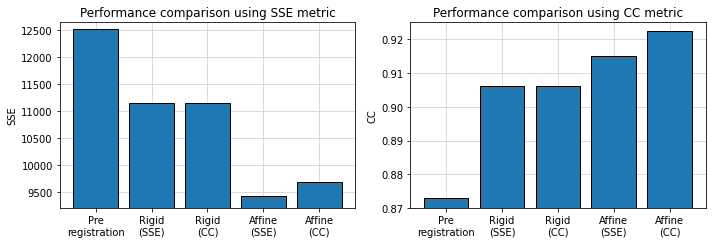

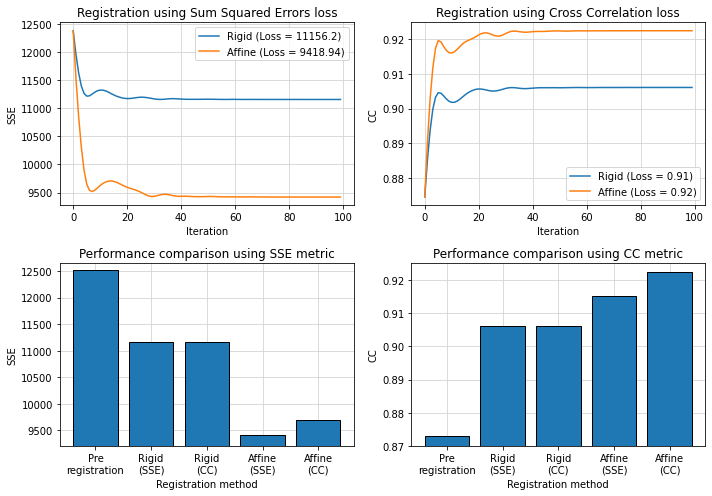

In [12]:
# Comparison using SSE metric
sse_metrics = [sse(B2, B1).numpy(),
               sse(B2, B3_rigid_sse).numpy(), 
               sse(B2, B3_rigid_cc).numpy(), 
               sse(B2, B3_affine_sse).numpy(), 
               sse(B2, B3_affine_cc).numpy()]
cc_metrics = [cross_corr(B2, B1).numpy(),
              cross_corr(B2, B3_rigid_sse).numpy(), 
              cross_corr(B2, B3_rigid_cc).numpy(), 
              cross_corr(B2, B3_affine_sse).numpy(), 
              cross_corr(B2, B3_affine_cc).numpy()]               
x = np.arange(5)
names = ['Pre\nregistration','Rigid\n(SSE)','Rigid\n(CC)','Affine\n(SSE)','Affine\n(CC)']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 3.5))
ax1.bar(x, height=sse_metrics, zorder=2, edgecolor='black')
ax1.set_title("Performance comparison using SSE metric")
ax1.set_ylim(9200,12650)
ax1.set_ylabel("SSE")
ax1.grid(zorder=0, color="lightgray")
plt.sca(ax1)
plt.xticks(x, names)

ax2.bar(x, height=cc_metrics, zorder=2, edgecolor='black')
ax2.set_title("Performance comparison using CC metric")
ax2.set_ylim(0.87,0.925)
ax2.set_ylabel("CC")
ax2.grid(zorder=0, color="lightgray")
plt.sca(ax2)
plt.xticks(x, names)

fig.tight_layout()
plt.savefig(f"./Week7/plots_handin4/images_merged_loss.png", dpi=300)
plt.show()

# Plot loss progression and comparison all in one
fig, ((ax1, ax2),
      (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 7))

ax1.plot(loss_rigid_sse, label = f"Rigid (Loss = {loss_rigid_sse[len(loss_rigid_sse)-1]:.6})")
ax1.plot(loss_affine_sse, label = f"Affine (Loss = {loss_affine_sse[len(loss_affine_sse)-1]:.6})")
ax1.set_title('Registration using Sum Squared Errors loss')
ax1.set_ylabel("SSE")
ax1.set_xlabel("Iteration")
ax1.grid(zorder=0, color="lightgray")
ax1.legend()

ax2.plot(loss_rigid_cc, label = f"Rigid (Loss = {loss_rigid_cc[len(loss_rigid_cc)-1]:.2})")
ax2.plot(loss_affine_cc, label = f"Affine (Loss = {loss_affine_cc[len(loss_affine_cc)-1]:.2})")
ax2.set_title('Registration using Cross Correlation loss')
ax2.set_ylabel("CC")
ax2.set_xlabel("Iteration")
ax2.grid(zorder=0, color="lightgray")
ax2.legend()

ax3.bar(x, height=sse_metrics, zorder=2, edgecolor='black')
ax3.set_title("Performance comparison using SSE metric")
ax3.set_ylim(9200,12650)
ax3.set_ylabel("SSE")
ax3.set_xlabel("Registration method")
ax3.grid(zorder=0, color="lightgray")
plt.sca(ax3)
plt.xticks(x, names)

ax4.bar(x, height=cc_metrics, zorder=2, edgecolor='black')
ax4.set_title("Performance comparison using CC metric")
ax4.set_ylim(0.87,0.925)
ax4.set_ylabel("CC")
ax4.set_xlabel("Registration method")
ax4.grid(zorder=0, color="lightgray")
plt.sca(ax4)
plt.xticks(x, names)


fig.tight_layout()
plt.savefig(f"./Week7/plots_handin4/images_loss_and_comparison.png", dpi=300)
plt.show()